In [ ]:
!pip install torch torchvision
!pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-xmf3rlim
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-xmf3rlim
  Running command git checkout -q 686c8666d31d932ed42d3cd7319f249fc75e89a9
  Using cached https://files.pythonhosted.org/packages/81/ee/3709513b414c2b525e4f03c45215579f93f41dba797f0e5fe539e6bc92b7/fvcore-0.1.1.post20200716.tar.gz
  Using cached https://files.pythonhosted.org/packages/38/4f/fe9a4d472aa867878ce3bb7efb16654c5d63672b86dc0e6e953a67018433/yacs-0.1.8-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/64/c2/b80047c7ac2478f9501676c988a5411ed5572f35d1beff9cae07d321512c/PyYAML-5.3.1.tar.gz
  Using cached https://files.pythonhosted.org/packages/89/a6/3814b7107e0788040870e8825eebf214d72166adf656ba7d4bf14759a06a/portalocker-2.0.0-py2.py3-none-any.whl
  Created wheel for pytorch3d: filename=pytorch3d-0.2.0-cp36-cp36m-linux_x86_64.whl size=1016580

In [ ]:
import torch
import numpy as np
from tqdm.notebook import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte

# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes, Textures

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# rendering components
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights
)

In [ ]:
!mkdir -p data


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Load the obj and ignore the textures and materials.
verts, faces_idx, _ = load_obj("./data/cow.obj")
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = Textures(verts_rgb=verts_rgb.to(device))

center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

teapot_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

/usr/local/lib/python3.6/dist-packages/pytorch3d/io/obj_io.py:70: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")


In [ ]:
cameras = OpenGLPerspectiveCameras(device=device)


blend_params = BlendParams(sigma=1e-4, gamma=1e-4)


raster_settings = RasterizationSettings(
    image_size=2048, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)
# We can add a point light in front of the object. 
lights = PointLights(device=device, location=((0, 0, 3),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights)
)

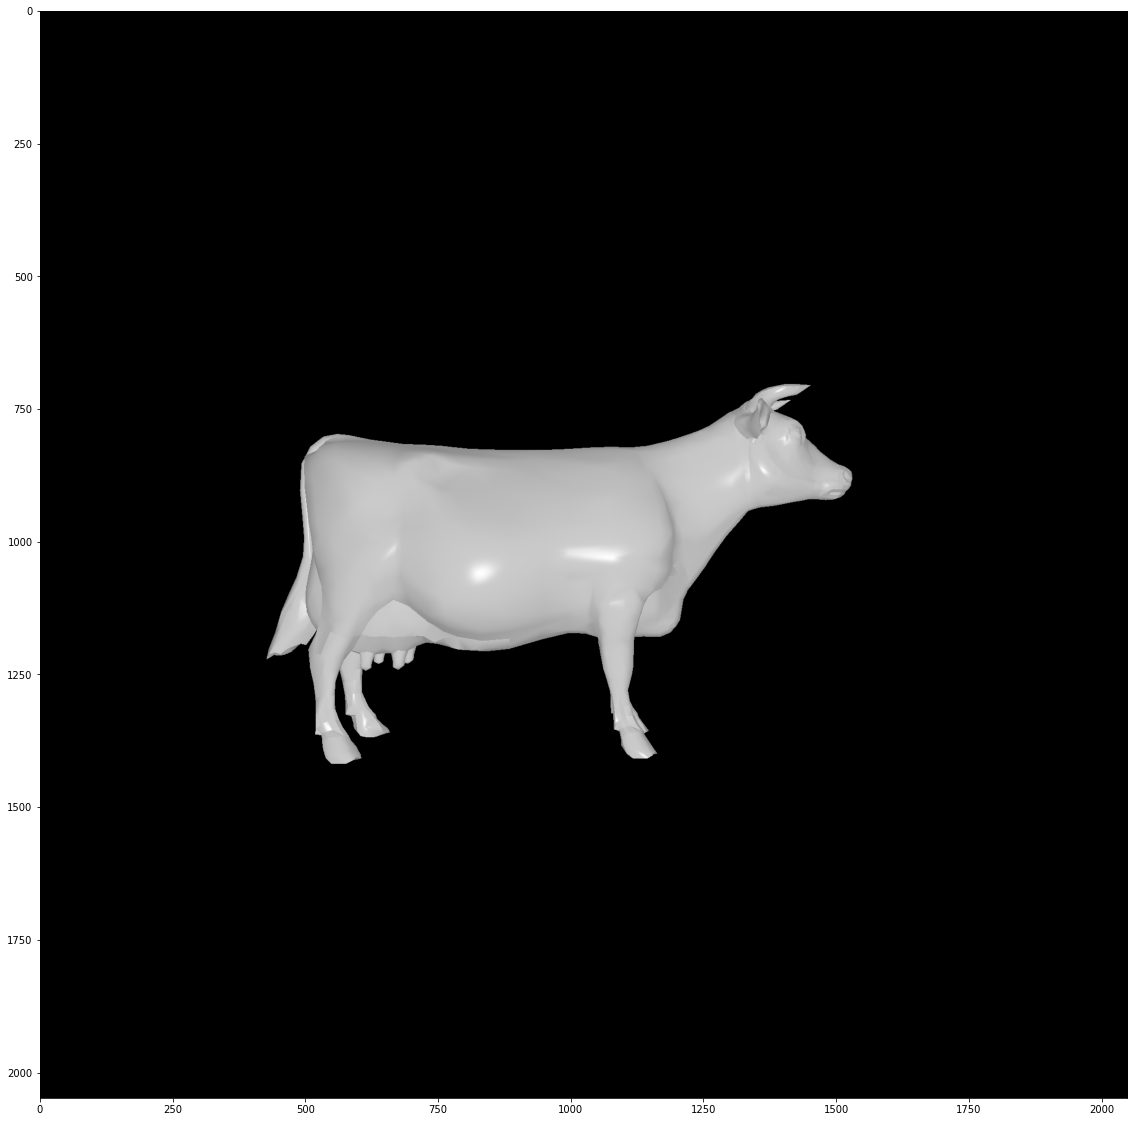

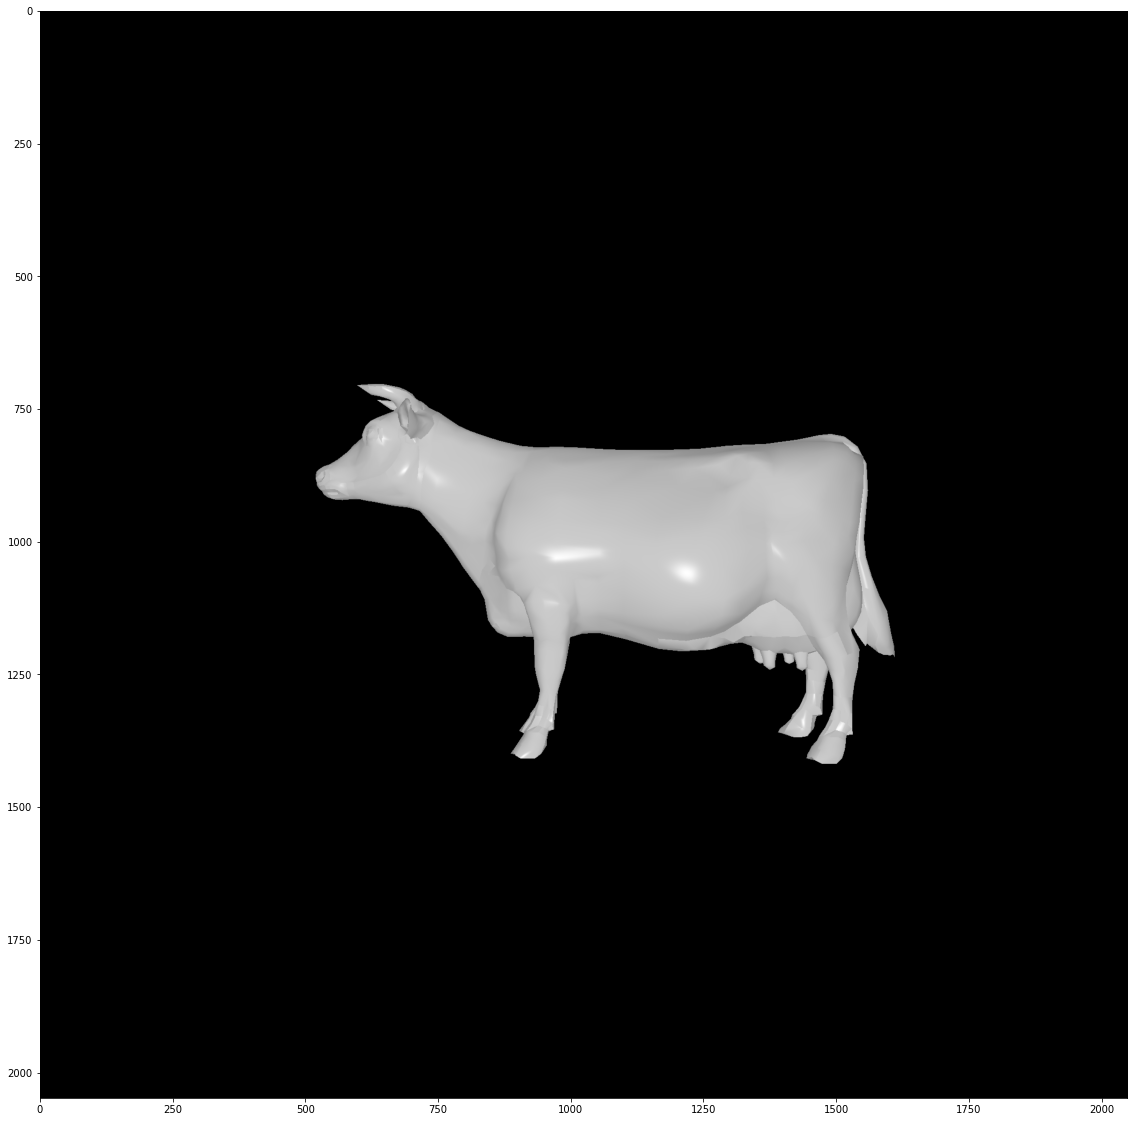

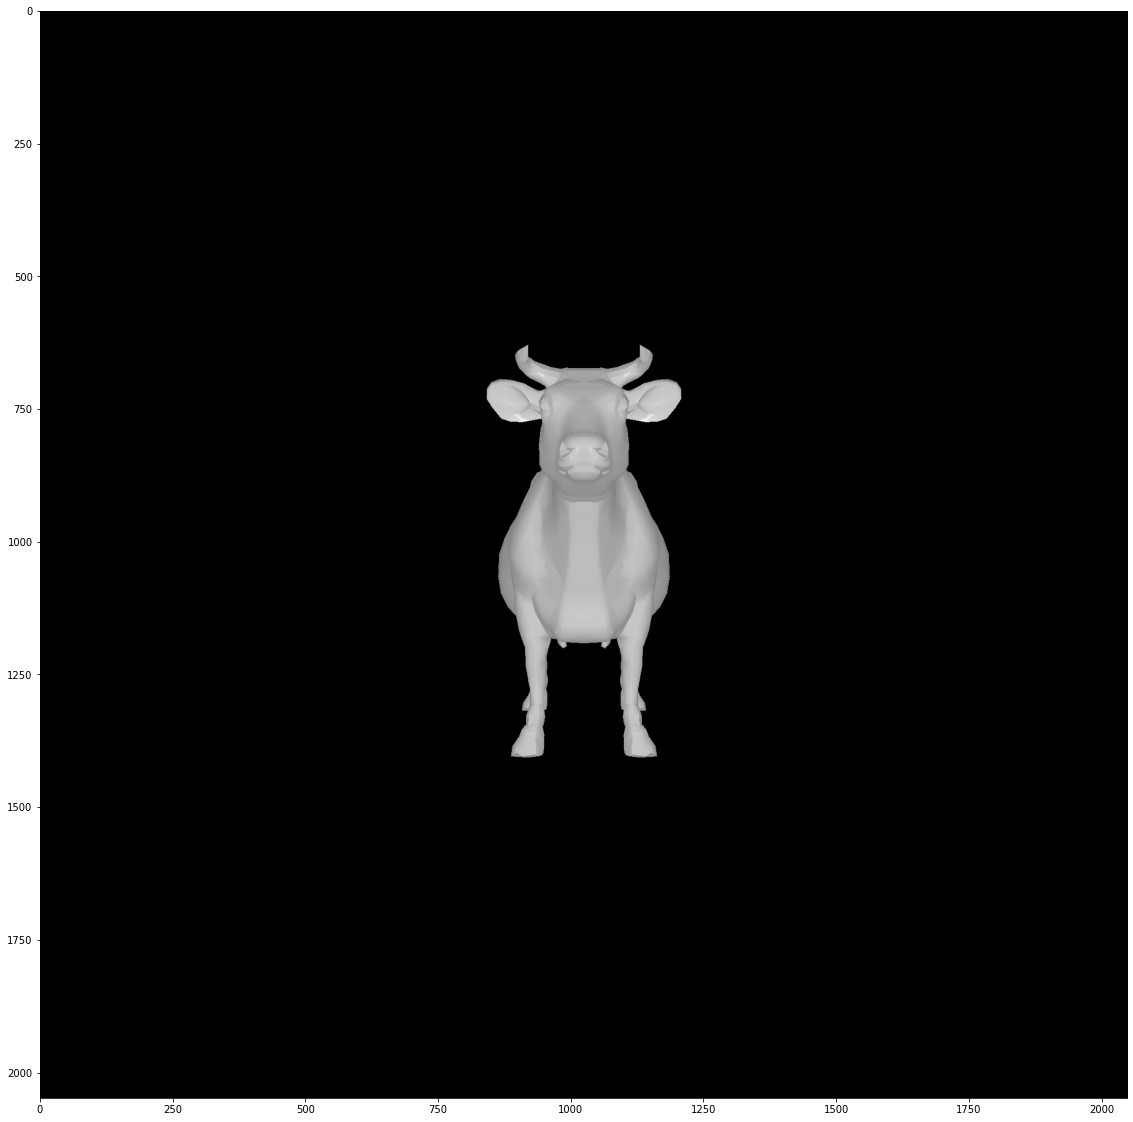

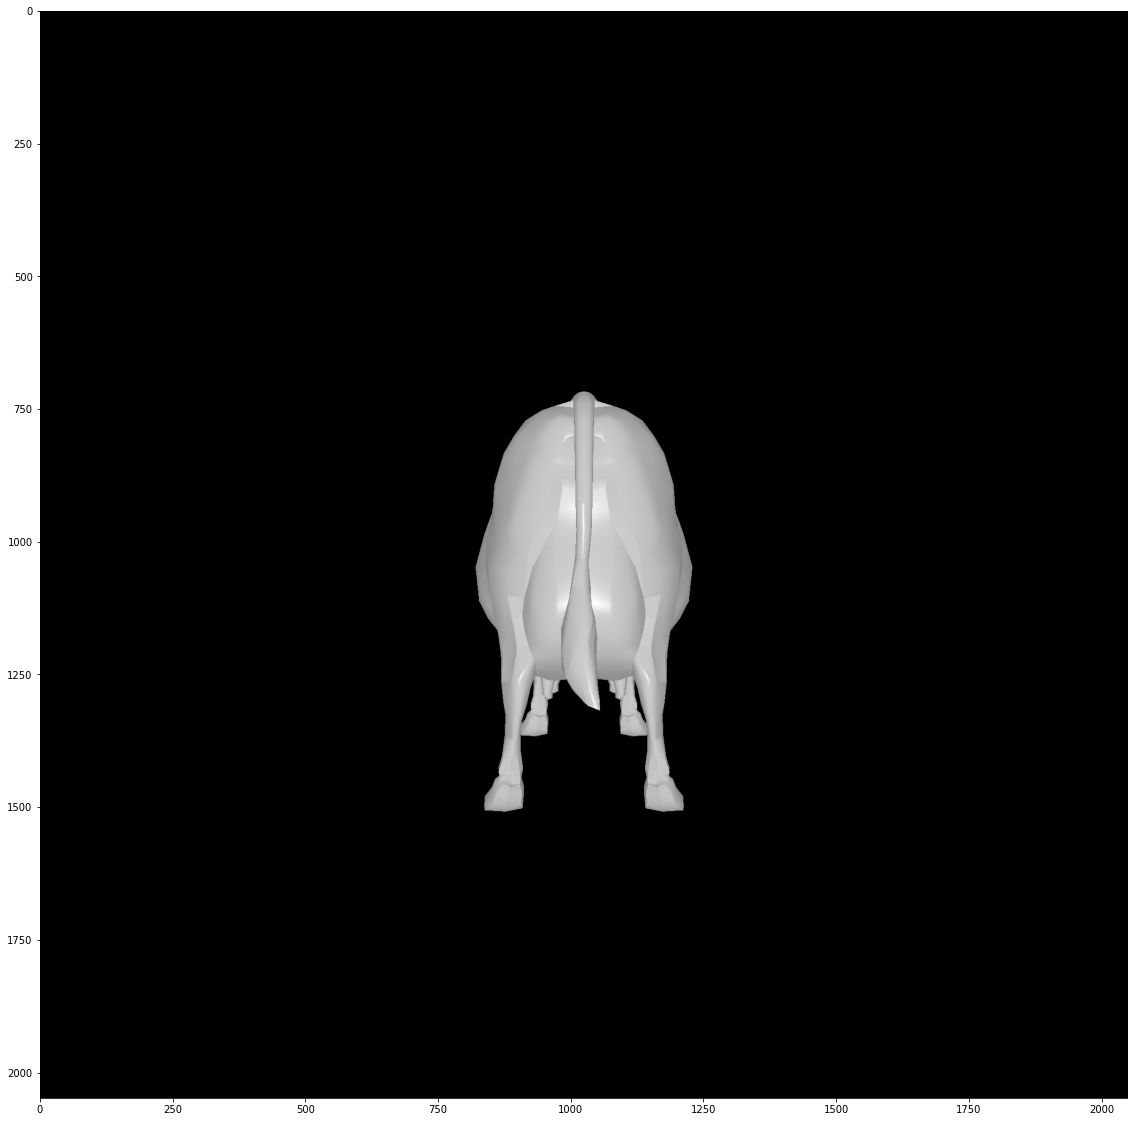

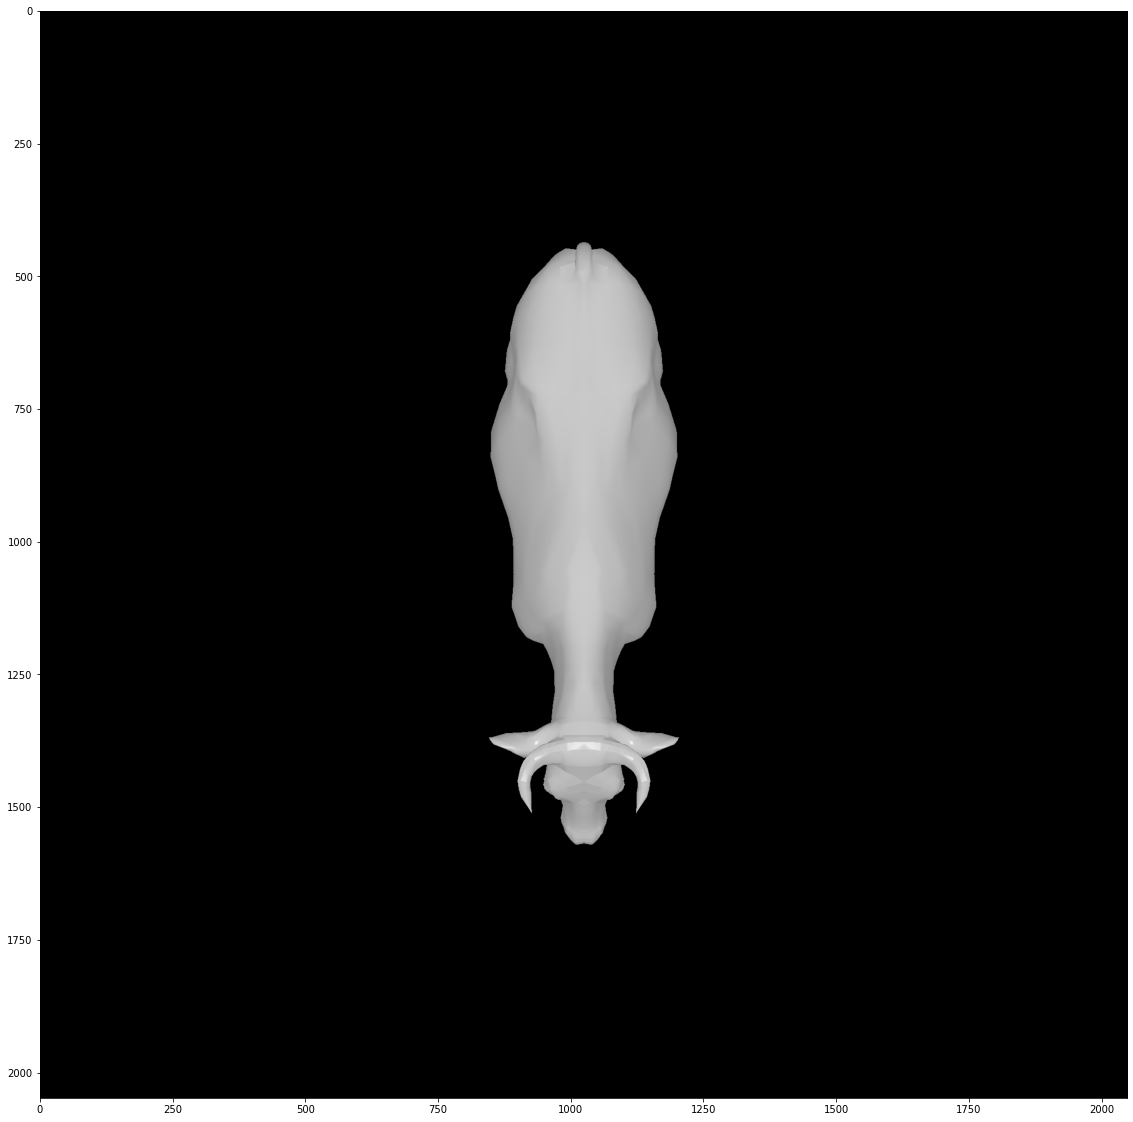

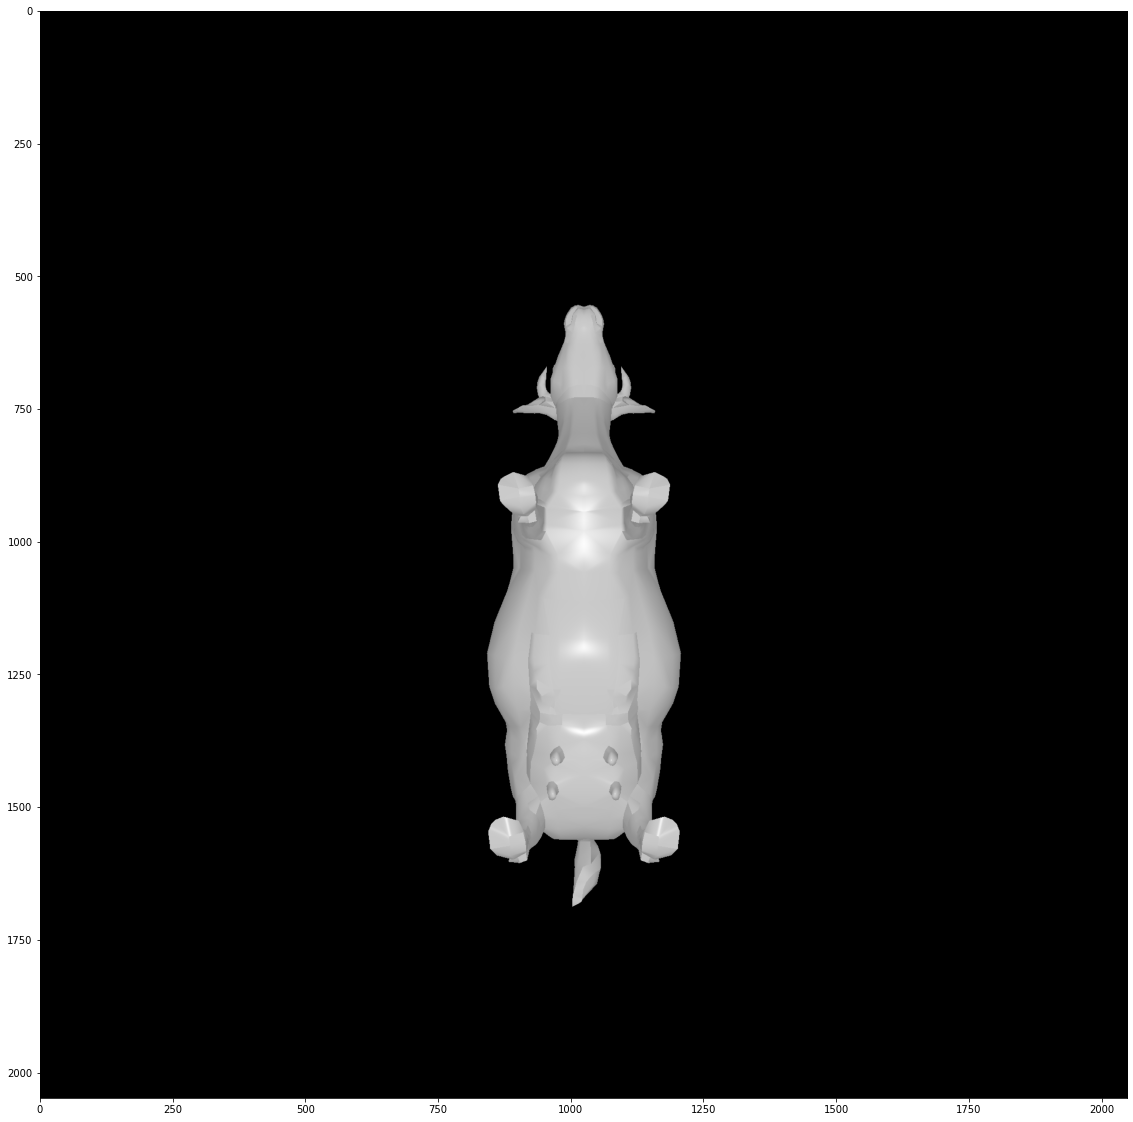

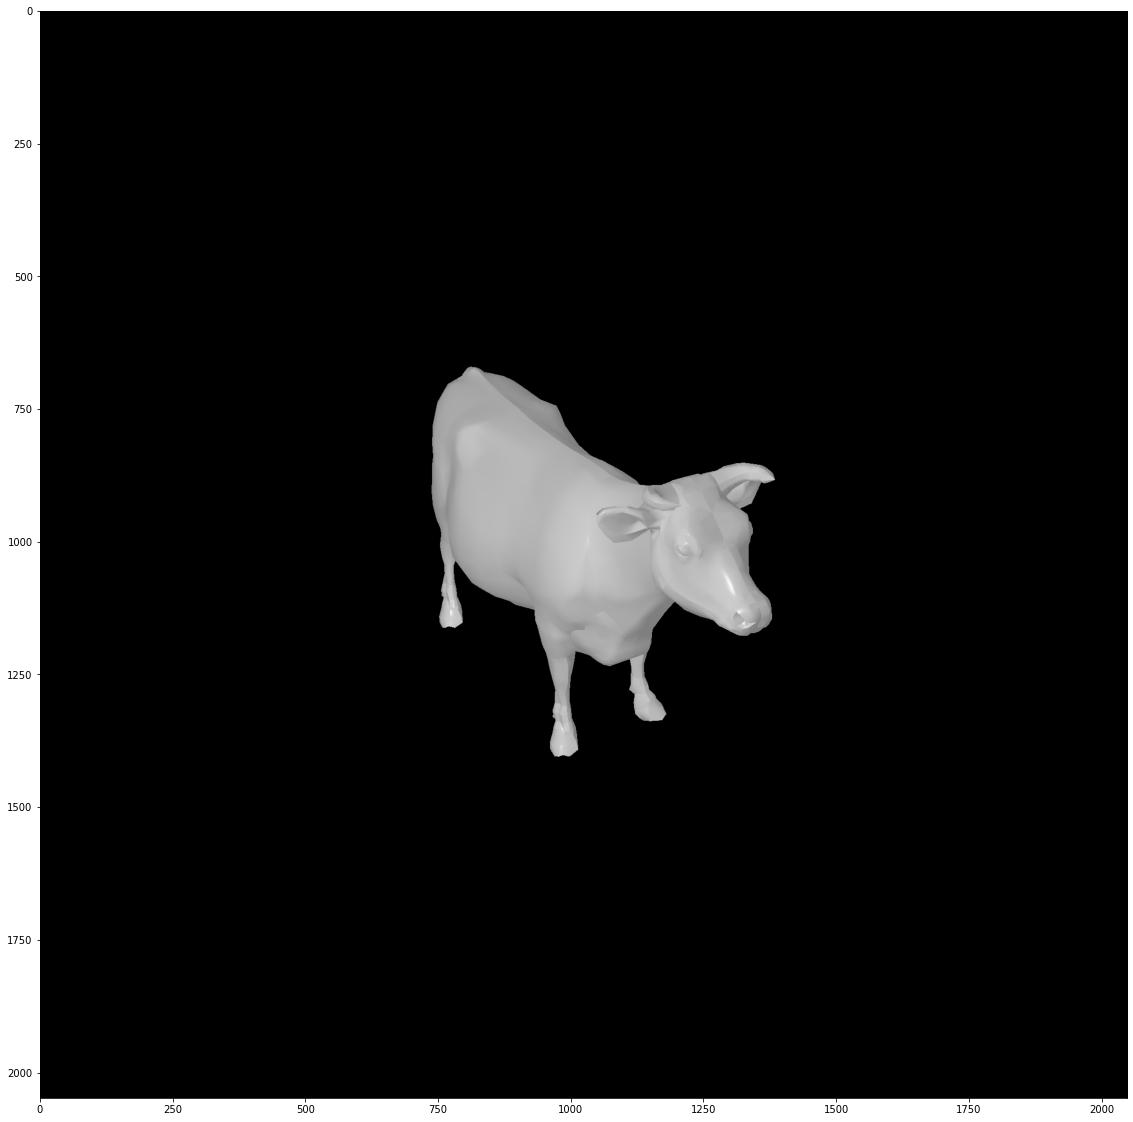

In [ ]:
distance = 3 # distance from camera to the object
elevation = 0   # angle of elevation in degrees
azimuth = 0  # No rotation so the camera is positioned on the +Z axis. 


#record==(i,elevation,azimuth,location)
#[2,0,180,0,0,-3],[3,0,90,3,0,0],[4,0,-90,-3,-0,0],[5,89,90,0,3,0],[6,-89,90,0,-3,0]
plist=[[1,0,0,0,0,3],[2,0,180,0,0,-3],[3,0,90,3,0,0],[4,0,-90,-3,-0,0],[5,89,90,0,3,0],[6,-89,90,0,-3,0],[7,30,60,1,1,1]]
for record in plist: 
  
  R, T = look_at_view_transform(dist=3, elev=record[1], azim=record[2])
  cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)
  lights.location = torch.tensor([[record[3],record[4],record[5]]], device=device)
     

  image_ref = phong_renderer(meshes_world=teapot_mesh,cameras=cameras,lights=lights)

  image_ref = image_ref.cpu().numpy()
  plt.figure(figsize=(20, 20))
  plt.imshow(image_ref.squeeze())
  plt.grid(False)

In [ ]:
fname="cow"
distance = 3 # distance from camera to the object
elevation = 0   # angle of elevation in degrees
azimuth = 0  # No rotation so the camera is positioned on the +Z axis. 

plist=[[1,0,0,0,0,3],[2,0,180,0,0,-3],[3,0,90,3,0,0],[4,0,-90,-3,-0,0],[5,89.999,90,0,3,0],[6,-89,90,0,-3,0],[7,30,60,1,1,1]]
nam=['0','1','2','3','4','5','6','7'];

for record in plist: 
  R, T = look_at_view_transform(dist=2, elev=record[1], azim=record[2])
  cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)
  lights.location = torch.tensor([[record[3],record[4],record[5]]], device=device)
     

  image_ref = phong_renderer(meshes_world=teapot_mesh,cameras=cameras,lights=lights)

  image_ref = image_ref.cpu().numpy()

  plt.imsave(fname+nam[record[0]]+'.png',image_ref.squeeze())
  